In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch

if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [139]:
import os
import numpy as np
from torchvision import transforms
from PIL import Image, ImageOps

from src.dataset.footprint2pressure import Footprint2Pressure_Blend

# @DATASET_REGISTRY.register()
class Footprint2Pressure_Blend_SensorPatch(Footprint2Pressure_Blend):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.resize = transforms.Resize((self.img_size, self.img_size))

        self.index = []

        for subject in self.pedar_dynamic.index.get_level_values(1).drop_duplicates():
            if os.path.isfile(self.footprint_wrap_folder / f'{subject}-L.jpg'):
                for patch_id in range(1, 199):
                    self.index.append((subject, patch_id))
    
    def __getitem__(self, index: int, blend_weight: np.array = None) -> tuple:
        subject, sensor_id = self.index[index]
        
        # blend weights
        if blend_weight is None:
            blend_weight = np.random.rand(5)
            blend_weight = blend_weight / blend_weight.sum()

        # weight blends young modulus & pedar arrays
        arr_pedar = self.pedar_dynamic.loc[(slice(None), subject), sensor_id].values / self.sense_range
        blend_pedar = torch.tensor(
            (arr_pedar * blend_weight).sum(axis=0),
            dtype=self.dtype,
            )
        blend_young = torch.tensor(
            (np.array(list(self.material_youngs.values())) * blend_weight).sum(),
            dtype=self.dtype,
            )
        
        # load footprint image and slice out the sensor-specific patch
        if sensor_id < 99:
            img = Image.open(self.footprint_wrap_folder / f'{subject}-L.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            img_patch = img_arr[self.x_grid['L'][sensor_id - 1], self.y_grid['L'][sensor_id - 1]]

        else:
            img = Image.open(self.footprint_wrap_folder / f'{subject}-R.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            img_patch = img_arr[self.x_grid['L'][sensor_id - 1 - 99], self.y_grid['L'][sensor_id - 1 - 99]]
        
        img_patch = self.resize(
            torch.tensor(img_patch, dtype=self.dtype).unsqueeze(0)
            )[0]
        
        return (img_patch.to(self.device), blend_young.to(self.device)), blend_pedar.to(self.device)

In [140]:
self = Footprint2Pressure_Blend_SensorPatch(
    device = device,
    footprint_wrap_folder = '../../data/processed/footprint-wrap/',
    pedar_dynamic_path = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
    sense_range = 600,
    stack_range = 50,
    img_size = 10,
)

In [141]:
len(self), self.index

(9900,
 [('S1', 1),
  ('S1', 2),
  ('S1', 3),
  ('S1', 4),
  ('S1', 5),
  ('S1', 6),
  ('S1', 7),
  ('S1', 8),
  ('S1', 9),
  ('S1', 10),
  ('S1', 11),
  ('S1', 12),
  ('S1', 13),
  ('S1', 14),
  ('S1', 15),
  ('S1', 16),
  ('S1', 17),
  ('S1', 18),
  ('S1', 19),
  ('S1', 20),
  ('S1', 21),
  ('S1', 22),
  ('S1', 23),
  ('S1', 24),
  ('S1', 25),
  ('S1', 26),
  ('S1', 27),
  ('S1', 28),
  ('S1', 29),
  ('S1', 30),
  ('S1', 31),
  ('S1', 32),
  ('S1', 33),
  ('S1', 34),
  ('S1', 35),
  ('S1', 36),
  ('S1', 37),
  ('S1', 38),
  ('S1', 39),
  ('S1', 40),
  ('S1', 41),
  ('S1', 42),
  ('S1', 43),
  ('S1', 44),
  ('S1', 45),
  ('S1', 46),
  ('S1', 47),
  ('S1', 48),
  ('S1', 49),
  ('S1', 50),
  ('S1', 51),
  ('S1', 52),
  ('S1', 53),
  ('S1', 54),
  ('S1', 55),
  ('S1', 56),
  ('S1', 57),
  ('S1', 58),
  ('S1', 59),
  ('S1', 60),
  ('S1', 61),
  ('S1', 62),
  ('S1', 63),
  ('S1', 64),
  ('S1', 65),
  ('S1', 66),
  ('S1', 67),
  ('S1', 68),
  ('S1', 69),
  ('S1', 70),
  ('S1', 71),
  ('S1',

In [143]:
(img_patch, blend_young), blend_pedar = self.__getitem__(199)
img_patch.shape, blend_young.shape, blend_pedar.shape

(torch.Size([10, 10]), torch.Size([]), torch.Size([]))

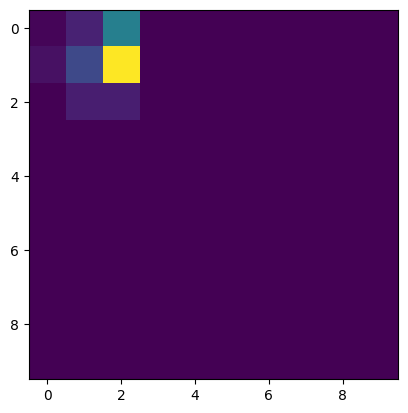

In [134]:
from matplotlib import pyplot as plt

plt.imshow(img_patch.cpu().detach().numpy())
plt.show()